# Segmentation

In [1]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 9.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=e72e64c2de229321724b639d7219b8c02a724416bfba1cb5bf54383514a852e9
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=614d366a3dbbbe5bd25cae6865a369993cdfd6277bb55690b6602797e5355409
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 34.56 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [4]:
TRAIN_DATA_PATH = '/kaggle/working/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/kaggle/working'

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

EPOCHS = 20
LR = 0.05
IMG_SIZE = 320
BATCH_SIZE = 32

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [5]:
df = pd.read_csv(TRAIN_DATA_PATH)
print(df.shape)
df.head()

(290, 2)


,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [6]:
sample = df.iloc[np.random.randint(0, df.shape[0], size=5)]

def generate_sample_images(sample):
    imgs = sample.images

    _, ax = plt.subplots(1, 5, figsize=(15,3))
    ax = ax.flatten()

    for i, image in enumerate(imgs):
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax[i].set_title("IMAGE")
        ax[i].imshow(image)

def generate_sample_masks(sample):
    masks = sample.masks

    _, ax = plt.subplots(1, 5, figsize=(15,3))
    ax = ax.flatten()

    for i, mask in enumerate(masks):
        mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE) / 255.0

        ax[i].set_title("GROUND TRUTH")
        ax[i].imshow(mask, cmap='gray')

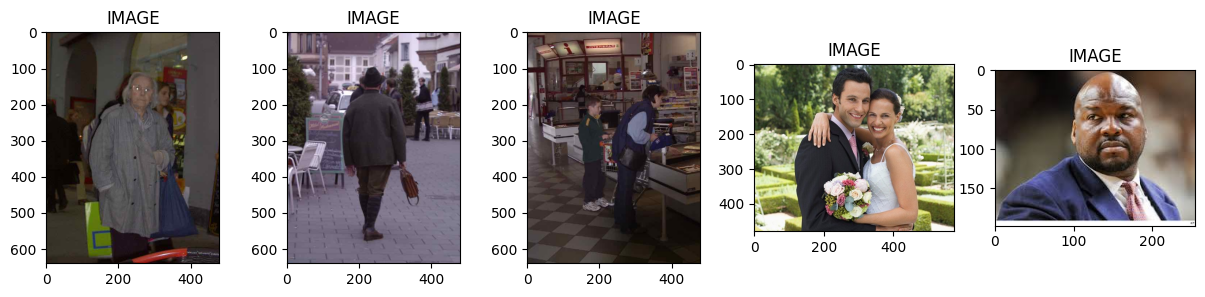

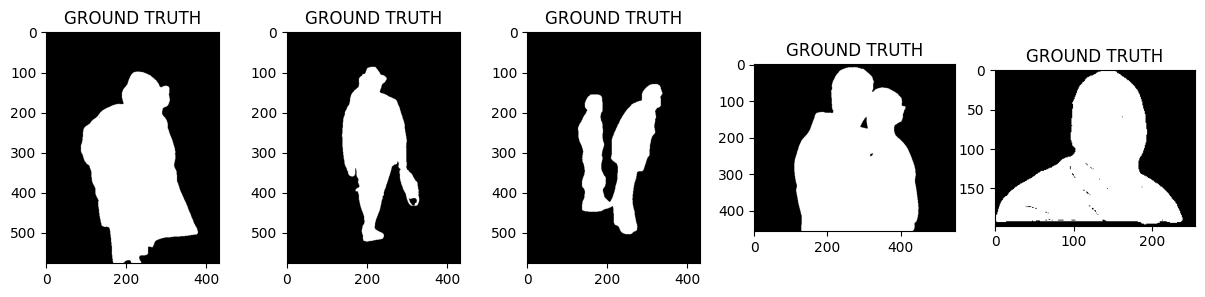

In [7]:
generate_sample_images(sample)
generate_sample_masks(sample)

In [8]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=57)

In [9]:
import albumentations as A

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [10]:
def get_train_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)
    ], is_check_shapes=False)

def get_val_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE)
    ], is_check_shapes=False)

In [11]:
class SegmentationDataset(Dataset):
    def __init__(self, df, augs):
        self.df = df
        self.augs = augs

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        image = sample.images
        mask = sample.masks

        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)

        # print(f"Shapes of images before augmentation: {image.shape}")
        # print(f"Shapes of masks before augmentation: {mask.shape}")

        if self.augs:
            data = self.augs(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        # print(f"\nShapes of images after augmentation: {image.shape}")
        # print(f"Shapes of masks after augmentation: {mask.shape}")

        image = np.transpose(image, (2,0,1)).astype(np.float32)
        mask = np.transpose(mask, (2,0,1)).astype(np.float32)

        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask

In [12]:
train_data = SegmentationDataset(train_df, get_train_augs())
val_data = SegmentationDataset(val_df, get_val_augs())

In [13]:
print(f"Size of Trainset : {len(train_data)}")
print(f"Size of Validset : {len(val_data)}")

Size of Trainset : 232
Size of Validset : 58


In [14]:
def processed_image(idx):
    image, mask = train_data[idx]

    plt.subplot(1,2,1)
    plt.imshow(np.transpose(image, (1,2,0)))
    plt.axis('off')
    plt.title("IMAGE");

    plt.subplot(1,2,2)
    plt.imshow(np.transpose(mask, (1,2,0)), cmap='gray')
    plt.axis('off')
    plt.title("GROUND TRUTH");
    plt.show()

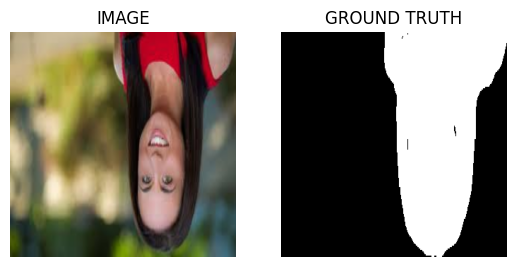

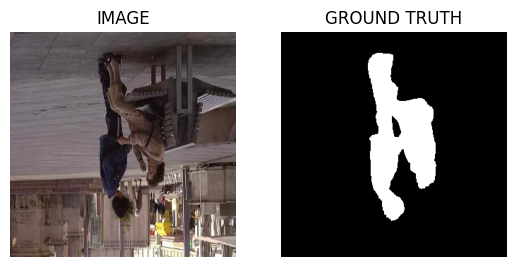

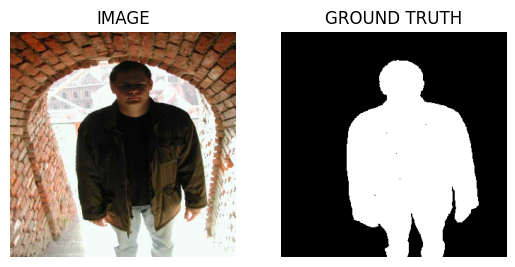

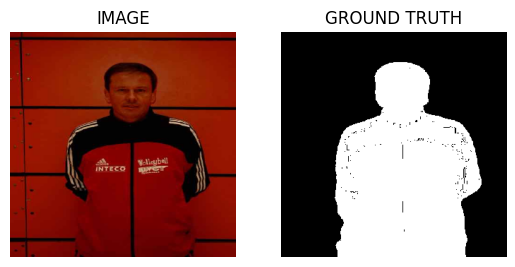

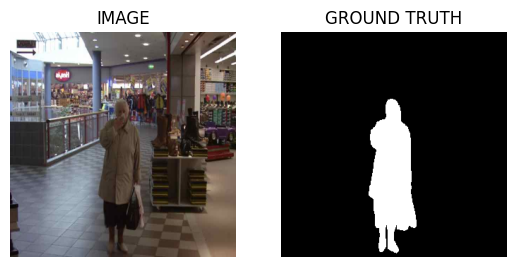

In [15]:
for i in np.random.randint(0, len(train_data), 5):
    processed_image(i)

In [16]:
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

print(f"Total number of batches in Train Loader: {len(trainloader)}")
print(f"Total number of batches in Val Loader: {len(valloader)}")

Total number of batches in Train Loader: 8
Total number of batches in Val Loader: 2


In [17]:
for image, mask in trainloader:
    print(f"Size of one batch of images: {image.shape}")
    print(f"Size of one batch of masks: {mask.shape}")
    break

Size of one batch of images: torch.Size([32, 3, 320, 320])
Size of one batch of masks: torch.Size([32, 1, 320, 320])


In [18]:
class SegmentationModel(nn.Module):
    def __init__(self, norm_loss=False, lambda_reg=0.01):
        super(SegmentationModel, self).__init__()
        self.norm_loss = norm_loss
        self.lambda_reg = lambda_reg

        self.model = smp.UnetPlusPlus(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None)

    def forward(self, images, masks=None):
        logits = self.model(images)

        if masks is not None:
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)

            if self.norm_loss:
                L_nl = torch.tensor(0.0, device=images.device)

                for name, param in self.model.named_parameters():
                    if "weight" in name:
                        dim = tuple(range(1, param.ndim))
                        norms = torch.norm(param, p=2, dim=dim)

                        L_nl += torch.sum((1 - norms) ** 2)

                final_loss = (loss1 + loss2) + self.lambda_reg * L_nl
            else:
                final_loss = loss1 + loss2

            return logits, final_loss

        return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE)

In [20]:
def train_model(data_loader, model, optimizer):
    total_loss = 0.0
    model.train()

    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [21]:
def eval_model(data_loader, model):
    total_loss = 0.0
    model.eval()

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)
            total_loss += loss.item()

        return total_loss / len(data_loader)

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
best_val_loss = 1e9
train_losses, val_losses = [], []

for i in range(EPOCHS):
    train_loss = train_model(trainloader, model, optimizer)
    val_loss = eval_model(valloader, model)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pt')
        print("MODEL SAVED")

        best_val_loss = val_loss

    print(f"\033[1m\033[92m Epoch {i+1} Train Loss {train_loss} Val Loss {val_loss}")

100%|██████████| 2/2 [00:00<00:00,  2.52it/s]


MODEL SAVED
 Epoch 1 Train Loss 1.3138335347175598 Val Loss 122777532.0


100%|██████████| 2/2 [00:00<00:00,  2.51it/s]


MODEL SAVED
 Epoch 2 Train Loss 1.0050551742315292 Val Loss 26325.3857421875


100%|██████████| 2/2 [00:00<00:00,  2.61it/s]


MODEL SAVED
 Epoch 3 Train Loss 0.8873645439743996 Val Loss 49.07185745239258


100%|██████████| 2/2 [00:00<00:00,  2.53it/s]


MODEL SAVED
 Epoch 4 Train Loss 0.8469133600592613 Val Loss 22.102206230163574


100%|██████████| 2/2 [00:00<00:00,  2.41it/s]


 Epoch 5 Train Loss 0.791587308049202 Val Loss 22.35942840576172


100%|██████████| 2/2 [00:00<00:00,  2.60it/s]


MODEL SAVED
 Epoch 6 Train Loss 0.8162529468536377 Val Loss 2.8732913732528687


100%|██████████| 2/2 [00:00<00:00,  2.55it/s]


MODEL SAVED
 Epoch 7 Train Loss 0.8108238950371742 Val Loss 1.3126127123832703


100%|██████████| 2/2 [00:00<00:00,  2.53it/s]


MODEL SAVED
 Epoch 8 Train Loss 0.7602885290980339 Val Loss 0.9723456799983978


100%|██████████| 2/2 [00:00<00:00,  2.51it/s]


 Epoch 9 Train Loss 0.7589663416147232 Val Loss 1.4523237943649292


100%|██████████| 2/2 [00:00<00:00,  2.51it/s]


 Epoch 10 Train Loss 0.7675715461373329 Val Loss 1.015489399433136


100%|██████████| 2/2 [00:00<00:00,  2.45it/s]


MODEL SAVED
 Epoch 11 Train Loss 0.7025797590613365 Val Loss 0.9292187988758087


100%|██████████| 2/2 [00:00<00:00,  2.50it/s]


 Epoch 12 Train Loss 0.7052527070045471 Val Loss 0.9859523773193359


100%|██████████| 2/2 [00:00<00:00,  2.53it/s]


MODEL SAVED
 Epoch 13 Train Loss 0.7303504720330238 Val Loss 0.8122154772281647


100%|██████████| 2/2 [00:00<00:00,  2.49it/s]


 Epoch 14 Train Loss 0.6993157938122749 Val Loss 0.8857819139957428


100%|██████████| 2/2 [00:00<00:00,  2.47it/s]


 Epoch 15 Train Loss 0.6959385350346565 Val Loss 0.9545788168907166


100%|██████████| 2/2 [00:00<00:00,  2.48it/s]


 Epoch 16 Train Loss 0.700667530298233 Val Loss 1.0576382875442505


100%|██████████| 2/2 [00:00<00:00,  2.41it/s]


 Epoch 17 Train Loss 0.7040619999170303 Val Loss 0.8749944269657135


100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


MODEL SAVED
 Epoch 18 Train Loss 0.6960892155766487 Val Loss 0.6948139369487762


100%|██████████| 2/2 [00:00<00:00,  2.45it/s]


 Epoch 19 Train Loss 0.7303853556513786 Val Loss 0.9353598952293396


100%|██████████| 2/2 [00:00<00:00,  2.45it/s]

 Epoch 20 Train Loss 0.6705614775419235 Val Loss 1.0714061856269836


In [ ]:
model_norm = SegmentationModel(norm_loss=True, lambda_reg=0.00001)
model_norm.to(DEVICE)

In [24]:
model_norm.model.decoder.blocks.x_2_3.conv2 = nn.Identity()
model_norm.model.decoder.blocks.x_2_3.attention2 = nn.Identity()
model_norm.model.decoder.blocks.x_3_3.conv2 = nn.Identity()
model_norm.model.decoder.blocks.x_3_3.attention2 = nn.Identity()
model_norm.model.decoder.blocks.x_0_4.conv2 = nn.Identity()
model_norm.model.decoder.blocks.x_0_4.attention2 = nn.Identity()

In [25]:
model_norm.model.decoder.blocks.x_0_4.forward

<bound method DecoderBlock.forward of DecoderBlock(
  (conv1): Conv2dReLU(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (attention1): Attention(
    (attention): Identity()
  )
  (conv2): Identity()
  (attention2): Identity()
)>

In [26]:
optimizer = torch.optim.Adam(model_norm.parameters(), lr=LR)
best_val_loss = 1e9
train_losses_norm, val_losses_norm = [], []

for i in range(EPOCHS):
    train_loss_norm = train_model(trainloader, model_norm, optimizer)
    val_loss_norm = eval_model(valloader, model_norm)
    train_losses_norm.append(train_loss_norm)
    val_losses_norm.append(val_loss_norm)

    if val_loss_norm < best_val_loss:
        torch.save(model_norm.state_dict(), 'best_model_norm.pt')
        print("MODEL SAVED")

        best_val_loss = val_loss_norm

    print(f"\033[1m\033[92m Epoch {i+1} Train Loss {train_loss_norm} Val Loss {val_loss_norm}")

100%|██████████| 2/2 [00:00<00:00,  2.49it/s]


 Epoch 1 Train Loss 2.208025097846985 Val Loss 1374069129216.0


100%|██████████| 2/2 [00:00<00:00,  2.53it/s]


MODEL SAVED
 Epoch 2 Train Loss 2.159856364130974 Val Loss 68958.4765625


100%|██████████| 2/2 [00:00<00:00,  2.49it/s]


MODEL SAVED
 Epoch 3 Train Loss 1.955924317240715 Val Loss 5.5373289585113525


100%|██████████| 2/2 [00:00<00:00,  2.47it/s]


MODEL SAVED
 Epoch 4 Train Loss 1.743912473320961 Val Loss 2.6270902156829834


100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


MODEL SAVED
 Epoch 5 Train Loss 1.4966100603342056 Val Loss 1.7469545602798462


100%|██████████| 2/2 [00:00<00:00,  2.44it/s]


MODEL SAVED
 Epoch 6 Train Loss 1.3612344563007355 Val Loss 1.5482020378112793


100%|██████████| 2/2 [00:00<00:00,  2.48it/s]


MODEL SAVED
 Epoch 7 Train Loss 1.2761807590723038 Val Loss 1.4369863867759705


100%|██████████| 2/2 [00:00<00:00,  2.44it/s]


MODEL SAVED
 Epoch 8 Train Loss 1.163093939423561 Val Loss 1.2871015071868896


100%|██████████| 2/2 [00:00<00:00,  2.51it/s]


 Epoch 9 Train Loss 1.0562569499015808 Val Loss 1.3414320349693298


100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


 Epoch 10 Train Loss 0.9937067925930023 Val Loss 1.632700800895691


100%|██████████| 2/2 [00:00<00:00,  2.44it/s]


MODEL SAVED
 Epoch 11 Train Loss 0.9056616351008415 Val Loss 0.9499366879463196


100%|██████████| 2/2 [00:00<00:00,  2.45it/s]


MODEL SAVED
 Epoch 12 Train Loss 0.8692212924361229 Val Loss 0.9075464010238647


100%|██████████| 2/2 [00:00<00:00,  2.49it/s]


 Epoch 13 Train Loss 0.8386171460151672 Val Loss 0.9229040443897247


100%|██████████| 2/2 [00:00<00:00,  2.44it/s]


MODEL SAVED
 Epoch 14 Train Loss 0.8062576130032539 Val Loss 0.8197595477104187


100%|██████████| 2/2 [00:00<00:00,  2.42it/s]


MODEL SAVED
 Epoch 15 Train Loss 0.7671234458684921 Val Loss 0.7925467491149902


100%|██████████| 2/2 [00:00<00:00,  2.44it/s]


 Epoch 16 Train Loss 0.8195513784885406 Val Loss 0.9157053828239441


100%|██████████| 2/2 [00:00<00:00,  2.41it/s]


 Epoch 17 Train Loss 0.7891171425580978 Val Loss 1.1279680132865906


100%|██████████| 2/2 [00:00<00:00,  2.52it/s]


 Epoch 18 Train Loss 0.8001425489783287 Val Loss 0.9467284679412842


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


MODEL SAVED
 Epoch 19 Train Loss 0.7905518785119057 Val Loss 0.7831883728504181


100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

 Epoch 20 Train Loss 0.7308278307318687 Val Loss 0.9318334460258484


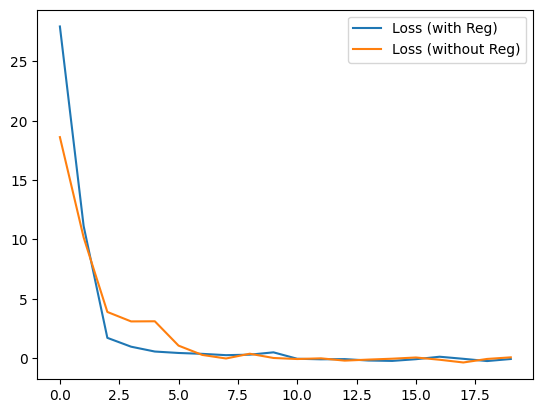

In [27]:
plt.plot(np.log(val_losses_norm), label="Loss (with Reg)")
plt.plot(np.log(val_losses), label="Loss (without Reg)")
plt.legend()
plt.show()

In [28]:
model.load_state_dict(torch.load("best_model.pt"))
model_norm.load_state_dict(torch.load("best_model_norm.pt"))

def make_inference(idx):
    image, mask = val_data[idx]
    logits_mask = model(image.to(DEVICE).unsqueeze(0))
    logits_mask_norm = model_norm(image.to(DEVICE).unsqueeze(0))

    pred_mask = torch.sigmoid(logits_mask)
    pred_mask = (pred_mask > 0.5) * 1.0
    pred_mask_norm = torch.sigmoid(logits_mask_norm)
    pred_mask_norm = (pred_mask_norm > 0.5) * 1.0

    return image, mask, pred_mask, pred_mask_norm

<ipython-input-28-0a009546c1ab>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))
<ipython-input-28-0a009546c1ab>:2: Future

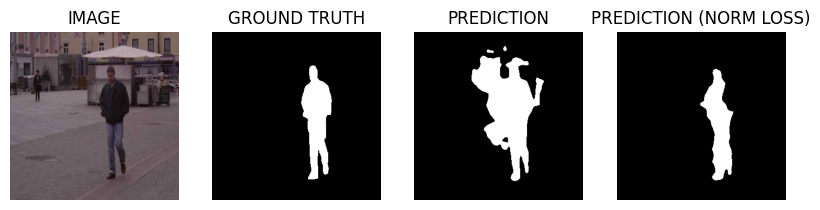

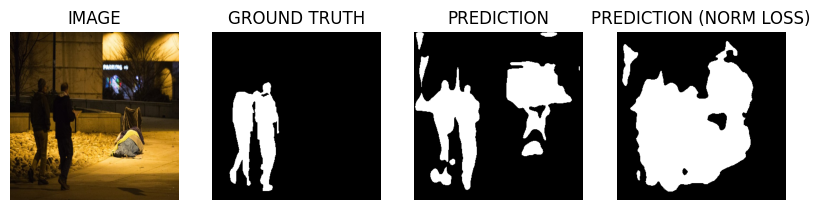

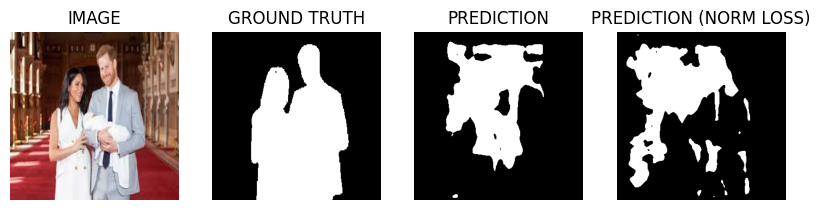

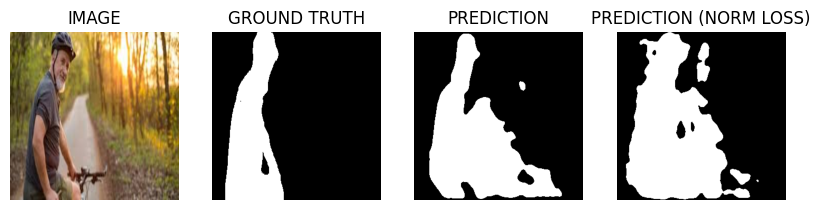

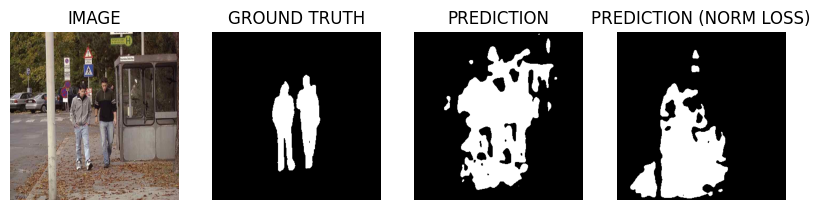

In [29]:
for i in np.random.randint(0, len(val_data), 5):

    image, mask, pred_mask, pred_mask_norm = make_inference(i)

    plt.figure(figsize=(10,4))
    plt.subplot(1,4,1)
    plt.imshow(np.transpose(image, (1,2,0)))
    plt.axis('off')
    plt.title('IMAGE');

    plt.subplot(1,4,2)
    plt.imshow(np.transpose(mask, (1,2,0)), cmap='gray')
    plt.axis('off')
    plt.title('GROUND TRUTH');

    plt.subplot(1,4,3)
    plt.imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)), cmap='gray')
    plt.axis('off')
    plt.title('PREDICTION');

    plt.subplot(1,4,4)
    plt.imshow(np.transpose(pred_mask_norm.detach().cpu().squeeze(0), (1,2,0)), cmap='gray')
    plt.axis('off')
    plt.title('PREDICTION (NORM LOSS)');

Test with overfitting (without regularization):

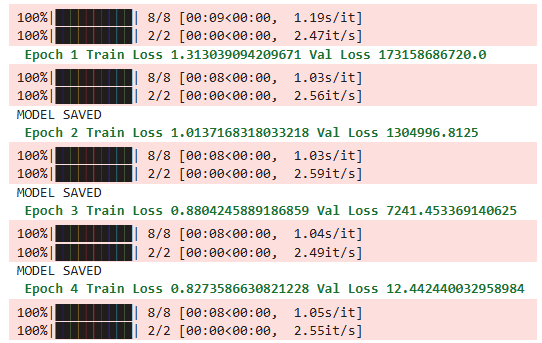

Test with overfitting (with regularization):

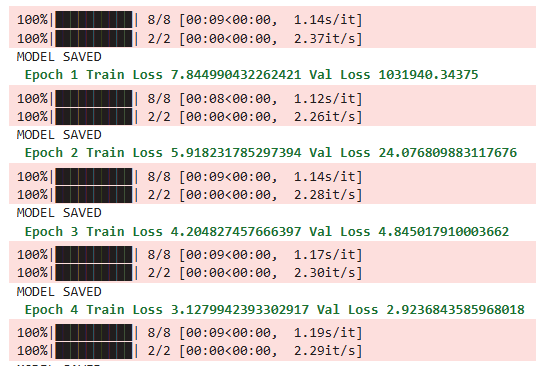